# Script to prepare data for YOLO training

In [79]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display

In [80]:
# Get csv paths
path_csv_train = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Audible/train_audible_recording_chunks.csv"
path_csv_test = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Audible/test_audible_recording_chunks.csv"
path_csv_val = "../../Dataset acoustique insectes/CSVs morceaux audio 5s/Audible/val_audible_recording_chunks.csv"

# Get spectrograms paths
path_spectro_train = "../../Dataset acoustique insectes/Sélection morceaux audio 5s/Audible/train_spectro"
path_spectro_test = "../../Dataset acoustique insectes/Sélection morceaux audio 5s/Audible/test_spectro"
path_spectro_val = "../../Dataset acoustique insectes/Sélection morceaux audio 5s/Audible/val_spectro"

path_spectro = [path_spectro_train, path_spectro_test, path_spectro_val]

# Using pandas to read the CSV file into a DataFrame
df_train = pd.read_csv(path_csv_train)
df_test = pd.read_csv(path_csv_test)
df_val = pd.read_csv(path_csv_val)

In [61]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])

def get_data_info(df):
    y = df['label']
    y_category = df['label_category']
    y_kingdom = df['label_kingdom']
    y_class = df['label_class']
    y_order = df['label_order']
    y_family = df['label_family']
    y_subfamily = df['label_subfamily']

    # Convertir les étiquettes en nombres
    y_encoded = label_encoder.transform(y)
    
    # create new empty dataframe
    new_df = pd.DataFrame()

    new_df['label'] = y_encoded
    new_df['t1'] = df["annotation_initial_time"] - df["chunk_initial_time"]
    new_df['t2'] = df["annotation_final_time"] - df["chunk_initial_time"]
    new_df['f1'] = df['min_frequency'].astype(int)
    new_df['f2'] = df['max_frequency'].astype(int)
    code_unique = df['code_unique'] 
    str_to_add = '_split_' + df['chunk_initial_time'].astype(str) + '_' + df['chunk_final_time'].astype(str)
    new_df['filename'] = code_unique + str_to_add + '.png'
    new_df['sr'] = df['sampling_rate']
    new_df['duration_chunk'] = df['chunk_final_time'] - df['chunk_initial_time']

    # Gestion des valeurs manquantes
    new_df = new_df.dropna()

    return new_df

info_train = get_data_info(df_train)
info_test = get_data_info(df_test)
info_val = get_data_info(df_val)

infos_data = [info_train, info_test, info_val]

In [56]:
info_train

,label,t1,t2,f1,f2,filename,sr,duration_chunk
0,65,0.355751,4.147038,0,375,Anura_XXXXigeXXES_01VII2022_330_split_0_5.png,44100,5
1,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_0_5.png,44100,5
2,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_5_10.png,44100,5
3,65,0.346426,1.708443,0,375,Anura_XXXXigeXXES_01VII2022_330_split_5_10.png,44100,5
4,22,0.000000,5.000000,3248,4453,Anura_XXXXigeXXES_01VII2022_330_split_10_15.png,44100,5
...,...,...,...,...,...,...,...,...
10784,9,2.296621,3.300916,5007,16160,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5
10785,9,4.691478,5.000000,4750,16553,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5
10786,9,0.000000,0.674299,5416,17367,Aves_KrDe_AwSw00PL_16VII2014_4613_split_175_18...,44100,5
10787,9,3.399642,3.863163,5007,15776,Aves_KrDe_AwSw00PL_16VII2014_4613_split_180_18...,44100,5


In [58]:
# prepare the data for the yolo dataset

# path to save the images and labels
path_yolo_dataset = "../../Dataset acoustique insectes/Sélection morceaux audio 5s/Audible/Yolo"

# create the directory if it does not exist
if not os.path.exists(path_yolo_dataset):
    os.makedirs(path_yolo_dataset)

# create the subdirectories if they do not exist
os.makedirs(os.path.join(path_yolo_dataset, 'images'), exist_ok=True)
os.makedirs(os.path.join(path_yolo_dataset, 'labels'), exist_ok=True)
    
# Path to the destination images and labels
path_dest_images_train = os.path.join(path_yolo_dataset, 'images', 'train')
path_dest_labels_train = os.path.join(path_yolo_dataset, 'labels', 'train')
path_dest_images_test = os.path.join(path_yolo_dataset, 'images', 'test')
path_dest_labels_test = os.path.join(path_yolo_dataset, 'labels', 'test')
path_dest_images_val = os.path.join(path_yolo_dataset, 'images', 'val')
path_dest_labels_val = os.path.join(path_yolo_dataset, 'labels', 'val')

path_dest_images = [path_dest_images_train, path_dest_images_test, path_dest_images_val]
path_dest_labels = [path_dest_labels_train, path_dest_labels_test, path_dest_labels_val]

# Create the destination directories
for d in path_dest_images:
    os.makedirs(d, exist_ok=True)
for d in path_dest_labels:
    os.makedirs(d, exist_ok=True)

In [59]:
# add the images to the images directory

# Loop for train, test and val
for i in range(len(path_dest_images)):
    # List all files in the source directory
    files = os.listdir(path_spectro[i])

    # Copy images to the destination directory
    for file in files:
        if file.endswith('.png'):  # Change the extension if your images have a different format
            source_path = os.path.join(path_spectro[i], file)
            dest_path = os.path.join(path_dest_images[i], file)
            shutil.copy(source_path, dest_path)

In [63]:
# add labels to the label directory

# Loop for train, test and val
for i in range(len(path_dest_labels)):
    info_data = infos_data[i]
    for elt in tqdm(info_data.iterrows()):
        # get the row values
        index, row = elt
        filename = row['filename']
        t1 = row['t1']
        t2 = row['t2']
        f1 = row['f1']
        f2 = row['f2']
        label = row['label']
        img_width, img_height = img.size
        chunk_duration = row['duration_chunk']
        
        # convert values to pixels
        t1_pixel = int(t1 * img_width/chunk_duration)
        t2_pixel = int(t2 * img_width/chunk_duration)
        f2_pixel = img_height - int(f1 * img_height/(row['sr']/2))
        f1_pixel = img_height - int(f2 * img_height/(row['sr']/2))
    
        # Normalize the coordinates
        t1_norm = t1_pixel/img_width
        t2_norm = t2_pixel/img_width
        f1_norm = f1_pixel/img_height
        f2_norm = f2_pixel/img_height
        
        # format : label x_center y_center width height
        x_center = (t1_norm + t2_norm)/2
        y_center = (f1_norm + f2_norm)/2
        width = t2_norm - t1_norm
        height = f2_norm - f1_norm
        
        # Create the label file
        label_file = filename.replace('.png', '.txt')
        
        # if the file already exists, we append the new bounding box
        if os.path.exists(os.path.join(path_dest_labels[i], label_file)):
            with open(os.path.join(path_dest_labels[i], label_file), 'a') as file:
                file.write(f"{label} {x_center} {y_center} {width} {height}\n")
        else:
            with open(os.path.join(path_dest_labels[i], label_file), 'w') as file:
                file.write(f"{label} {x_center} {y_center} {width} {height}\n")

10789it [00:42, 256.28it/s]
1414it [00:05, 238.70it/s]
1454it [00:05, 249.00it/s]


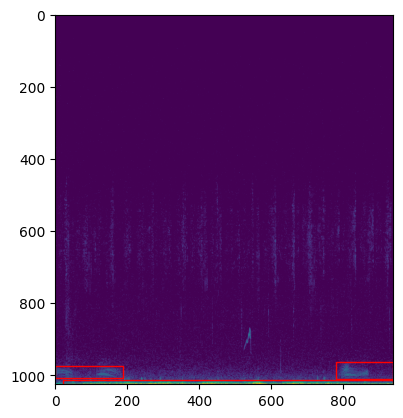

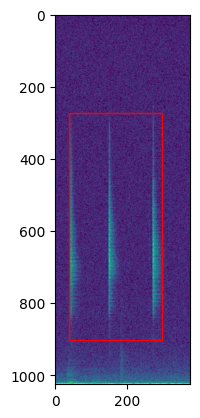

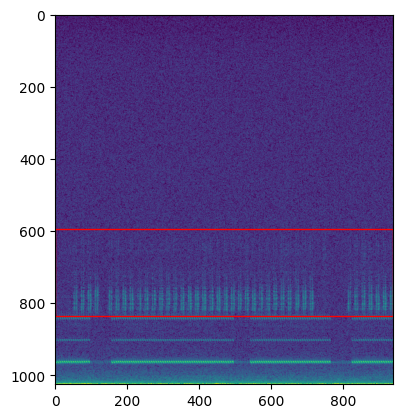

In [84]:
def draw_bounding_boxes(img_path, label_file):
    # Open the image
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)

    # Read the label file
    with open(label_file, 'r') as file:
        lines = file.readlines()
        plt.imshow(img)
        for line in lines:
            label, x_center, y_center, width, height = map(float, line.split())
            img_width, img_height = img.size
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            x1 = int(x_center - width/2)
            x2 = int(x_center + width/2)
            y1 = int(y_center - height/2)
            y2 = int(y_center + height/2)

            # Create a Rectangle patch
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            
    # Display the image with bounding boxes
    plt.show()

# train check
# get random id
id = random.randint(0, len(info_train))
img_path = os.path.join(path_dest_images_train, info_train.iloc[id]['filename'])
label_file = os.path.join(path_dest_labels_train, info_train.iloc[id]['filename'].replace('.png', '.txt'))
draw_bounding_boxes(img_path, label_file)

# test check
# get random id
id = random.randint(0, len(info_test))
img_path = os.path.join(path_dest_images_test, info_test.iloc[id]['filename'])
label_file = os.path.join(path_dest_labels_test, info_test.iloc[id]['filename'].replace('.png', '.txt'))
draw_bounding_boxes(img_path, label_file)

# val check
# get random id
id = random.randint(0, len(info_val))
img_path = os.path.join(path_dest_images_val, info_val.iloc[id]['filename'])
label_file = os.path.join(path_dest_labels_val, info_val.iloc[id]['filename'].replace('.png', '.txt'))
draw_bounding_boxes(img_path, label_file)




In [92]:
data_yaml = f"path: {os.getcwd()}\n" \
            f"train: {'images/train'}\n" \
            f"test: {'images/test'}\n" \
            f"val: {'images/val'}\n" \
            f"nc: {len(label_encoder.classes_)}\n" \
            f"names: {list(label_encoder.classes_)}\n"
            
# Create the yaml file
with open(os.path.join(path_yolo_dataset, 'data.yaml'), 'w') as file:
    file.write(data_yaml)


In [93]:
#test the data.yaml file
with open(os.path.join(path_yolo_dataset, 'data.yaml'), 'r') as file:
    print(file.read())
    

path: c:\Users\lucas\Documents\Annee_3_ENSEEIHT\Projet long\OrthopteraStridulationClassifier\Notebooks\YOLO
train: images/train
test: images/test
val: images/val
nc: 70
names: ['Apis mellifera', 'Avion', 'Barbitistes serricauda', 'Bombina variegata', 'Canis familiaris', 'Chorthippus apricarius', 'Chorthippus biguttulus', 'Chorthippus brunneus', 'Chorthippus vagans', 'Chrysochraon dispar', 'Cicada orni', 'Cicadatra atra', 'Cloche', 'Corvus corone', 'Curruca communis', 'Decticus albifrons', 'Decticus verrucivorus', 'Déplacement', 'Emberiza calandra', 'Ephippiger diurnus', 'Euchorthippus declivus', 'Euchorthippus elegantulus', 'Eumodicogryllus bordigalensis', 'Fringilla coelebs', 'Gomphocerippus mollis', 'Gryllotalpa gryllotalpa', 'Gryllus bimaculatus', 'Gryllus campestris', 'Hyla meridionalis', 'Leptophyes punctatissima', 'Luscinia megarhynchos', 'Lyristes plebejus', 'Melanogryllus desertus', 'Metrioptera saussuriana', 'Micro', 'Mouche', 'Myrmeleotettix maculatus', 'Nemobius sylvestris',